In [ ]:
Best_params: {'n_estimators': 5800, 'learning_rate': 0.02043558768623802, 'max_depth': 11, 'subsample': 0.6965645209738722, 'colsample_bytree': 0.9501111755200085, 'min_child_weight': 16, 'reg_alpha': 0.00048113504832999424, 'reg_lambda': 0.14593465805509478, 'tree_method': 'hist', 'enable_categorical': True, 'random_state': 42}

In [2]:
a=get_xgboost_data("data/processed_features.parquet")

⚡ Loading pre-processed data from data/processed_features.parquet...
Feature engineering complete! Splitting data based on users...


In [7]:
import pandas as pd
ret=pd.read_parquet("data/struggling_learners_all_pairs.parquet")

In [ ]:
ret.head()
user=ret[["user_id"]]

In [21]:
user.head(10)

,user_id
0,u:hSWF
1,u:hSWF
2,u:hSWF
3,u:hSWF
4,u:hSWF
5,u:hSWF
6,u:hSWF
7,u:hSWF
8,u:fwHX
9,u:fwHX


In [2]:

import pandas as pd
df=pd.read_parquet("data/processed_features.parquet")


In [4]:
df["days"]=df['delta'] / (60 * 60 * 24)

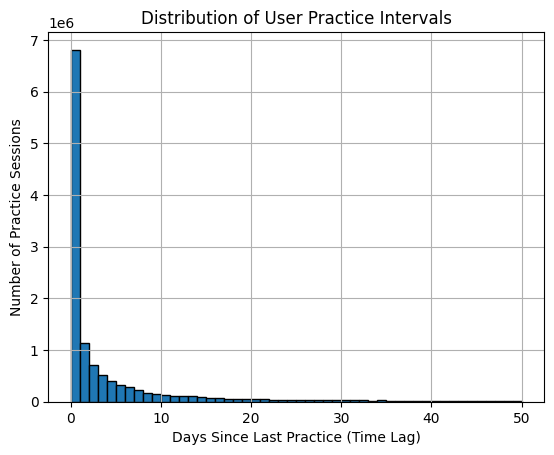

In [11]:

import matplotlib.pyplot as plt

# 1. Generate the plot (using Fix 2 from earlier as an example)
df['days'].hist(bins=50, range=(0, 50), color='#1f77b4', edgecolor='black')

# 2. NAME YOUR AXES
plt.xlabel("Days Since Last Practice (Time Lag)")  # ⬅️ The horizontal X-axis
plt.ylabel("Number of Practice Sessions")          # ⬅️ The vertical Y-axis
plt.title("Distribution of User Practice Intervals") # ⬅️ The main title

# 3. Show it
plt.show()

In [22]:
filtered_df = df[df['user_id'].isin(user['user_id'])]

In [27]:
filtered_df["user_id"].nunique()
filtered_df.to_parquet("data/slowLearn.parquet")

In [29]:
filtered_df["p_recall"].info

<bound method Series.info of 514         0.000000
515         0.000000
516         0.000000
517         1.000000
518         0.000000
              ...   
12849654    0.000000
12849655    0.333333
12849656    1.000000
12849657    1.000000
12849658    1.000000
Name: p_recall, Length: 713183, dtype: float64>

In [2]:
import pandas as pd

print("📂 Reading the space-separated file...")

# 1. Read the file. 
# sep='\s+' is the magic regex command that handles any amount of spaces or tabs.
df = pd.read_csv("../resultXGBoost.pred", sep='\s+')

# 2. Save it as a proper Comma-Separated Values (CSV) file
df.to_csv("../XGBpred.csv", index=False)

print("✅ Boom! File perfectly converted to clean_predictions.csv")

📂 Reading the space-separated file...
✅ Boom! File perfectly converted to clean_predictions.csv


In [ ]:
# src/data_pipeline.py
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold

def get_xgboost(processed_file_path="data/processed_features.parquet", user_fraction=1.0):
    print(f"⚡ Loading pre-processed data from {processed_file_path}...")
    df = pd.read_parquet(processed_file_path)
    
    if user_fraction < 1.0:
        print(f"Shrinking dataset to {user_fraction*100}% of users for a fast trial...")
        unique_users = df['user_id'].unique()
        np.random.seed(42) 
        sampled_users = np.random.choice(
            unique_users, 
            size=int(len(unique_users) * user_fraction), 
            replace=False
        )
        df = df[df['user_id'].isin(sampled_users)].copy()

    # Target variable
    y = df['p_recall'].clip(lower=0.0001, upper=0.9999)

    # Feature matrix
    X = pd.DataFrame()

    # Time features
    X['hour_of_day'] = df['timestamp'].dt.hour
    X['day_of_week'] = df['timestamp'].dt.dayofweek

    #Delta represents the time since last practice in days, which is critical for the forgetting curve
    #DECIDE WHICH ONE TO KEEP: raw delta or log delta (log can help with skew but may lose interpretability)
    X['time_lag_days'] = df['delta'] / (60 * 60 * 24)
    #X['log_delta'] = np.log1p(df['delta'] / (60 * 60 * 24))

    # Combine languages into a single feature
    X['lang'] = df['ui_language'] + "->" + df['learning_language']

    # MCM predictions
    X['mcm_predicted_p'] = df['mcm_predicted_p']

    # Accuracy features
    X['historical_accuracy'] = df['historical_accuracy'] # Micro: Their skill on this word
    X['user_global_accuracy'] = df['user_global_accuracy'] # Macro: Their overall app skill
    X['right'] = np.sqrt(1 + df['history_correct'])  #Raw success count (sqrt to reduce skew)
    X['wrong'] = np.sqrt(1 + (df['history_seen'] - df['history_correct']))  #Raw failure count (sqrt authors mentioned it works better)

    # --- NEW: Full grammatical feature set from enrich_chunk ---
    # pos_label: descriptive POS ("noun", "verb_lexical", "adjective", …)
    X['pos_label'] = df['pos_label'].fillna('unknown')
    X['tense'] = df['tense'].fillna('unknown')
    X['person'] = df['person'].fillna('unknown')
    X['grammatical_number'] = df['number'].fillna('unknown')   # enrich_chunk uses 'number'
    X['gender'] = df['gender'].fillna('unknown')
    X['case'] = df['case'].fillna('unknown')
    X['definiteness'] = df['definiteness'].fillna('unknown')
    X['degree'] = df['degree'].fillna('unknown')
    X['word_length'] = df['surface_form'].str.len()



    X['user_id']=df["user_id"]
    X['timestamp']=df["timestamp"]
    X['lexeme_string']=df["lexeme_string"]




    
    # Cast all categoricals for native XGBoost handling
    cat_cols = ['lang', 'pos_label', 'tense', 'person',
                'grammatical_number', 'gender', 'case', 'definiteness', 'degree',"user_id", "lexeme_string"]
    for col in cat_cols:
        X[col] = X[col].astype('category')

    
    print("Feature engineering complete! Splitting data based on users...")


    # Stratified split
    groups = df['user_id'].values
    gkf = GroupKFold(n_splits=10)
    train_idx, test_idx = next(gkf.split(X, y, groups=groups))
    
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

In [2]:
import pandas as pd
df=pd.read_parquet("data/processed_features.parquet")

In [1]:
df.shape

NameError: name 'df' is not defined

In [4]:
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
from src.config import MIN_HALF_LIFE, MAX_HALF_LIFE

optuna.logging.set_verbosity(optuna.logging.WARNING)

def train_xgboost(X_train, X_test, y_train, y_test, use_optuna=False, n_trials=300):
    print("Initializing XGBoost Regressor (Phase 2 Baseline)...")
    
    # Target Transformation: Calculate 'h' for training
    h_train = -X_train['time_lag_days'] / np.log2(y_train)
    h_train = np.clip(h_train, MIN_HALF_LIFE, MAX_HALF_LIFE)
    
    h_test = -X_test['time_lag_days'] / np.log2(y_test)
    h_test = np.clip(h_test, MIN_HALF_LIFE, MAX_HALF_LIFE)

    training_features = list(X_train.columns)

    if use_optuna:
        print(f"🔎 Running Optuna hyperparameter search ({n_trials} trials)...")

        def objective(trial):
            params = {
                "tree_method": "hist",
                "enable_categorical": True,
                "n_estimators": trial.suggest_int("n_estimators", 200, 8000, step=100),
                "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
                "random_state": 42,
                "early_stopping_rounds": 50,
            }
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train[training_features], h_train,
                eval_set=[(X_test[training_features], h_test)],
                verbose=False
            )
            h_pred = model.predict(X_test[training_features])
            h_pred = np.clip(h_pred, MIN_HALF_LIFE, MAX_HALF_LIFE)
            return mean_absolute_error(h_test, h_pred)

        study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        best_params = study.best_params
        best_params.update({"tree_method": "hist", "enable_categorical": True, "random_state": 42})
        print(f"\n✅ Best params: {best_params}")

        model = xgb.XGBRegressor(**best_params)
        model.fit(
            X_train[training_features], h_train,
            eval_set=[(X_train[training_features], h_train), (X_test[training_features], h_test)],
            verbose=50
        )
    else:
        model = xgb.XGBRegressor(
            tree_method="hist", 
            enable_categorical=True,
            n_estimators=200000,
            learning_rate=0.1   ,
            max_depth=6,
            early_stopping_rounds=50,
            random_state=42
        )
        model.fit(
            X_train[training_features], h_train,
            eval_set=[(X_train[training_features], h_train), (X_test[training_features], h_test)],
            verbose=50 # Prints update every 50 trees
        )

    # Predict h
    h_pred = model.predict(X_test[training_features])
    h_pred = np.clip(h_pred, MIN_HALF_LIFE, MAX_HALF_LIFE)
    
    # Transform h back to probability of recall (p)
    p_pred = 2.0 ** (-X_test['time_lag_days'] / h_pred)
    p_pred = np.clip(p_pred, 0.0001, 0.9999)

    predictions_df = pd.DataFrame({
        'p': y_test,          # True probability (Target)
        'pp': p_pred,                                # Predicted probability
        'h': h_test,            # True empirical half-life
        'hh': h_pred,                                # Predicted half-life
        'lang': X_test['lang'],
        'user_id': X_test['user_id'],
        'timestamp': X_test['timestamp'],
        'lexeme_tag': X_test['lexeme_string']
    })
    predictions_df.to_csv("resultXGBoost.pred", index=False, sep=' ')

    # Evaluation Metrics
    mae_h = mean_absolute_error(h_test, h_pred)
    spearman_h, _ = spearmanr(h_test, h_pred)
    mae_p = mean_absolute_error(y_test, p_pred)
    spearman_p, _ = spearmanr(y_test, p_pred)

    print("-" * 30)
    print("🏆 PHASE 2 RESULTS 🏆")
    print(f"  MAE (Days):           {mae_h:.4f}")
    print(f"  Spearman Correlation: {spearman_h:.4f}")
    print("-" * 40)
    print("RECALL PROBABILITY (p) PREDICTION:")
    print(f"  MAE:                  {mae_p:.4f}")
    print(f"  Spearman Correlation: {spearman_p:.4f}")
    print("-" * 30)
    
    return model


X_train, X_test, y_train, y_test = get_xgboost("data/processed_features.parquet")
    
    # 2. Model Training
model = train_xgboost(X_train, X_test, y_train, y_test)
    

⚡ Loading pre-processed data from data/processed_features.parquet...
Feature engineering complete! Splitting data based on users...
Initializing XGBoost Regressor (Phase 2 Baseline)...


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:lang: category, pos_label: category, tense: category, person: category, grammatical_number: category, gender: category, case: category, definiteness: category, degree: category, user_id: category, timestamp: datetime64[ns], lexeme_string: category